In [4]:

!mkdir -p ~/.kaggle/ && mv kaggle.json ~/.kaggle/ && chmod 600 ~/.kaggle/kaggle.json
!kaggle datasets download -d anshtanwar/jellyfish-types

 20% 5.00M/25.5M [00:00<00:00, 41.9MB/s]
100% 25.5M/25.5M [00:00<00:00, 130MB/s] 


In [5]:
# Get helper_functions.py script from course GitHub
!wget https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/helper_functions.py

# Import helper functions we're going to use
from helper_functions import create_tensorboard_callback, plot_loss_curves, unzip_data, walk_through_dir, pred_and_plot, load_and_prep_image


--2023-10-31 03:48:38--  https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/helper_functions.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 10246 (10K) [text/plain]
Saving to: ‘helper_functions.py.1’

helper_functions.py 100%[===================>]  10.01K  --.-KB/s    in 0.001s  

2023-10-31 03:48:38 (12.7 MB/s) - ‘helper_functions.py.1’ saved [10246/10246]



# Preprocess data

In [6]:
# Unzip dataset zip
unzip_data("/content/jellyfish-types.zip")

In [7]:
# See files in directory
walk_through_dir("/content/Train_Test_Valid")

There are 3 directories and 0 images in '/content/Train_Test_Valid'.
There are 6 directories and 0 images in '/content/Train_Test_Valid/test'.
There are 0 directories and 7 images in '/content/Train_Test_Valid/test/compass_jellyfish'.
There are 0 directories and 6 images in '/content/Train_Test_Valid/test/Moon_jellyfish'.
There are 0 directories and 7 images in '/content/Train_Test_Valid/test/blue_jellyfish'.
There are 0 directories and 7 images in '/content/Train_Test_Valid/test/mauve_stinger_jellyfish'.
There are 0 directories and 8 images in '/content/Train_Test_Valid/test/lions_mane_jellyfish'.
There are 0 directories and 5 images in '/content/Train_Test_Valid/test/barrel_jellyfish'.
There are 6 directories and 0 images in '/content/Train_Test_Valid/valid'.
There are 0 directories and 7 images in '/content/Train_Test_Valid/valid/compass_jellyfish'.
There are 0 directories and 6 images in '/content/Train_Test_Valid/valid/Moon_jellyfish'.
There are 0 directories and 7 images in '/con

In [8]:

# Get 10% of the data of the 10 classes
!wget https://storage.googleapis.com/ztm_tf_course/food_vision/10_food_classes_10_percent.zip

unzip_data("10_food_classes_10_percent.zip")

--2023-10-31 03:48:38--  https://storage.googleapis.com/ztm_tf_course/food_vision/10_food_classes_10_percent.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 74.125.195.207, 172.253.117.207, 142.250.99.207, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|74.125.195.207|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 168546183 (161M) [application/zip]
Saving to: ‘10_food_classes_10_percent.zip’

10_food_classes_10_ 100%[===================>] 160.74M   320MB/s    in 0.5s    

2023-10-31 03:48:39 (320 MB/s) - ‘10_food_classes_10_percent.zip’ saved [168546183/168546183]



In [9]:
# Dine train and test directories
train_dir = '/content/Train_Test_Valid/Train'
test_dir = "/content/Train_Test_Valid/test"

# # Create training and test directories
# train_dir = "10_food_classes_10_percent/train/"
# test_dir = "10_food_classes_10_percent/test/"

In [10]:
import tensorflow as tf

IMG_SIZE = (224, 224)
BATCH_SIZE=32

train_data = tf.keras.preprocessing.image_dataset_from_directory(
    train_dir,
    label_mode="categorical",
    image_size=IMG_SIZE,
    batch_size=BATCH_SIZE
)

test_data = tf.keras.preprocessing.image_dataset_from_directory(
    test_dir,
    label_mode="categorical",
    image_size=IMG_SIZE,
    batch_size=BATCH_SIZE
)

Found 900 files belonging to 6 classes.
Found 40 files belonging to 6 classes.


In [11]:
train_data

<_PrefetchDataset element_spec=(TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None, 6), dtype=tf.float32, name=None))>

In [12]:
# Classes from train_data
train_data.class_names

['Moon_jellyfish',
 'barrel_jellyfish',
 'blue_jellyfish',
 'compass_jellyfish',
 'lions_mane_jellyfish',
 'mauve_stinger_jellyfish']

In [13]:

# See an example batch of data
# for images, labels in train_data.take(1):
#   print(images.shape, labels)

images = train_data.take(1)
images

<_TakeDataset element_spec=(TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None, 6), dtype=tf.float32, name=None))>

# Create model_0

In [14]:
# 1. Create a base model with tf.keras.applications
base_model = tf.keras.applications.EfficientNetB0(include_top=False)

# 2. Freeze the base model
base_model.trainable = False

# 3. Create inputs into the base model
inputs = tf.keras.layers.Input(shape=IMG_SIZE + (3,), name="input_layer")

# 4. If using ResNet50V2, add this to speed up convergence, remove for EfficientNet
# x = tf.keras.layers.experimental.preprocessing.Rescaling(1./255)(inputs)

# 5. Pass the inputs to the base_model
x = base_model(inputs)
# Check data shape after passing it to base_model
print(f"Shape after base_model: {x.shape}")

# 6. Average pool the outputs of the base model
x = tf.keras.layers.GlobalAveragePooling2D(name="global_average_pooling_layer")(x)

# 7. Create the output activation layer
outputs = tf.keras.layers.Dense(len(train_data.class_names), activation="softmax", name="output_layer")(x)

# 8. Combine inputs with the outputs into a model
model_0 = tf.keras.Model(inputs, outputs)

# 9. Compile the model
model_0.compile(
    loss="categorical_crossentropy",
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
    metrics=['accuracy']
)

history_model_0 = model_0.fit(
    train_data,
    epochs=5,
     steps_per_epoch=len(train_data),
      validation_data=test_data,
        # Go through less of the validation data so epochs are faster (we want faster experiments!)
      validation_steps=len(test_data),
      # Track our model's training logs for visualization later
      callbacks=[create_tensorboard_callback("transfer_learning", "model_0_training")]
    )









16705208/16705208 [==============================] - 0s 0us/step
Shape after base_model: (None, 7, 7, 1280)
Saving TensorBoard log files to: transfer_learning/model_0_training/20231031-034850
Epoch 1/5
29/29 [==============================] - 33s 294ms/step - loss: 1.4725 - accuracy: 0.4744 - val_loss: 0.9874 - val_accuracy: 0.8000
Epoch 2/5
29/29 [==============================] - 3s 78ms/step - loss: 0.8361 - accuracy: 0.8067 - val_loss: 0.6491 - val_accuracy: 0.8750
Epoch 3/5
29/29 [==============================] - 3s 81ms/step - loss: 0.6095 - accuracy: 0.8667 - val_loss: 0.5176 - val_accuracy: 0.9000
Epoch 4/5
29/29 [==============================] - 2s 75ms/step - loss: 0.4825 - accuracy: 0.9011 - val_loss: 0.4579 - val_accuracy: 0.9000
Epoch 5/5
29/29 [==============================] - 2s 78ms/step - loss: 0.4154 - accuracy: 0.9144 - val_loss: 0.4129 - val_accuracy: 0.9000


In [15]:
model_0_results = model_0.evaluate(test_data)
model_0_results

2/2 [==============================] - 0s 26ms/step - loss: 0.4129 - accuracy: 0.9000


[0.4129165709018707, 0.8999999761581421]

In [16]:
# # Check layers in our base model
# for layer_number, layer in enumerate(base_model.layers):
#   print(layer_number, layer.name)

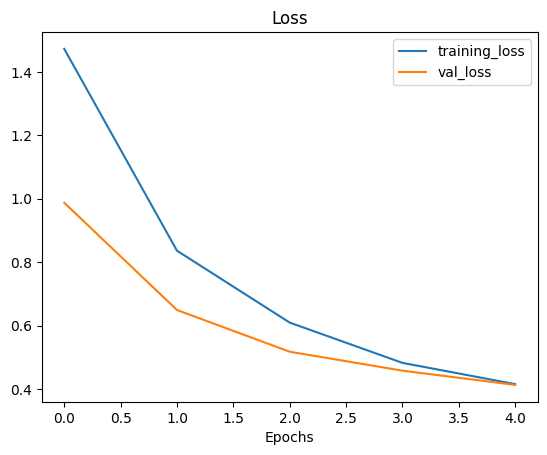

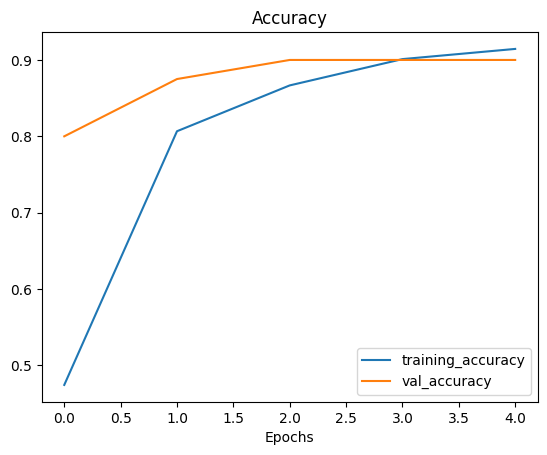

In [17]:
plot_loss_curves(history_model_0)

1/1 [==============================] - 3s 3s/step


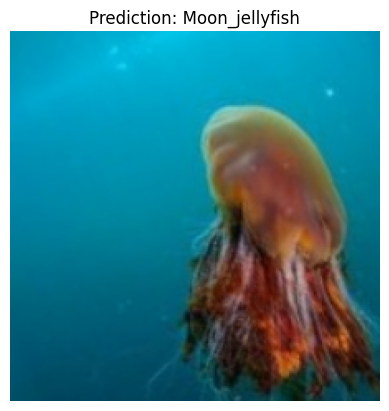

In [18]:
pred_and_plot(model_0, "/content/Train_Test_Valid/Train/lions_mane_jellyfish/aug-16-21.jpg",train_data.class_names )

Our model is predcting quite bad on the validation set

# Getting a feature vector from a trained model

## Running a series of transfer learning experiments

### Adding data augmentation right into the model

In [19]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.layers.experimental import preprocessing

# Create a data augmentation stage

data_augmentation = keras.Sequential([
    preprocessing.RandomFlip('horizontal'),
    preprocessing.RandomRotation(0.2),
    preprocessing.RandomZoom(0.2),
    preprocessing.RandomHeight(0.2),
    preprocessing.RandomHeight(0.2),
    preprocessing.RandomWidth(0.2)
], name="data_augmentation")

(-0.5, 201.5, 145.5, -0.5)

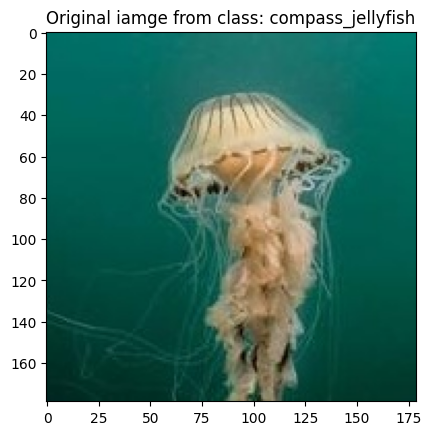

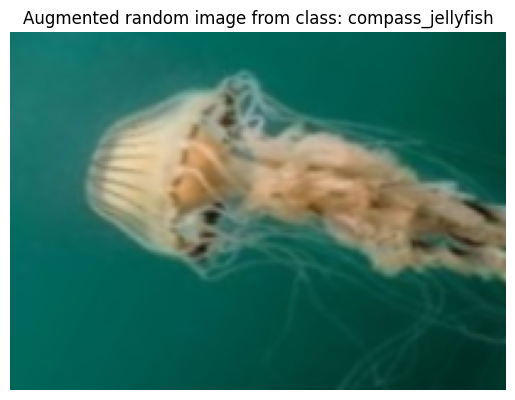

In [20]:
# View random image function

import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import os
import random

target_class = random.choice(train_data.class_names)
target_dir = "/content/Train_Test_Valid/Train/" + target_class
random_image = random.choice(os.listdir(target_dir))
random_image_path = target_dir + "/" + random_image
img = mpimg.imread(random_image_path)
plt.imshow(img)
plt.title(f"Original iamge from class: {target_class}")

# Augment image
augmented_img = data_augmentation(tf.expand_dims(img, axis=0))
plt.figure()
plt.imshow(tf.squeeze(augmented_img)/255.)
plt.title(f"Augmented random image from class: {target_class}")
plt.axis(False)

# Model 1: Feature extraction transfer learning on 1% of the data with data augmentation

In [23]:
# Setup input shape and base model, freezing the base model layers
input_shape = (224, 224, 3)
base_model = tf.keras.applications.EfficientNetB0(include_top=False)

base_model.trainable = False

# Create input layer
inputs = layers.Input(shape=input_shape, name="input_layer")

# Add in data augmentation Sequential model as a layer
x = data_augmentation(inputs)

# Give base_model inputs (after augmentation) and don't train it
x = base_model(x, training=False)

# Pool output features of base model
x = layers.GlobalAveragePooling2D(name="global_average_pooling_layer")(x)

# Put a dense layer on as the output
outputs = layers.Dense(len(train_data.class_names), activation="softmax", name="output_layer")(x)

# Make a model with inputs and outputs
model_1 = keras.Model(inputs, outputs)

# Compile the model
model_1.compile(
    loss="categorical_crossentropy",
    optimizer=tf.keras.optimizers.Adam(),
    metrics=['accuracy']
)
history_1_percent = model_1.fit(train_data,
                    epochs=5,
                    steps_per_epoch=len(train_data),
                    validation_data=test_data,
                    validation_steps=len(test_data) # validate for less steps


)

Epoch 1/5
29/29 [==============================] - 24s 597ms/step - loss: 1.4472 - accuracy: 0.4889 - val_loss: 1.0151 - val_accuracy: 0.7750
Epoch 2/5
29/29 [==============================] - 14s 457ms/step - loss: 0.8640 - accuracy: 0.7833 - val_loss: 0.7089 - val_accuracy: 0.8500
Epoch 3/5
29/29 [==============================] - 13s 446ms/step - loss: 0.6462 - accuracy: 0.8411 - val_loss: 0.5830 - val_accuracy: 0.8750
Epoch 4/5
29/29 [==============================] - 12s 402ms/step - loss: 0.5441 - accuracy: 0.8633 - val_loss: 0.5192 - val_accuracy: 0.8750
Epoch 5/5
29/29 [==============================] - 12s 412ms/step - loss: 0.4482 - accuracy: 0.8911 - val_loss: 0.4712 - val_accuracy: 0.9000


In [25]:
results_model_1 = model_1.evaluate(test_data)
results_model_1

2/2 [==============================] - 0s 42ms/step - loss: 0.4712 - accuracy: 0.9000


[0.4712126851081848, 0.8999999761581421]

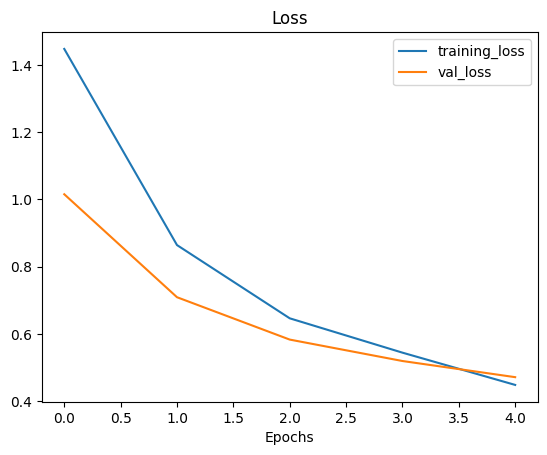

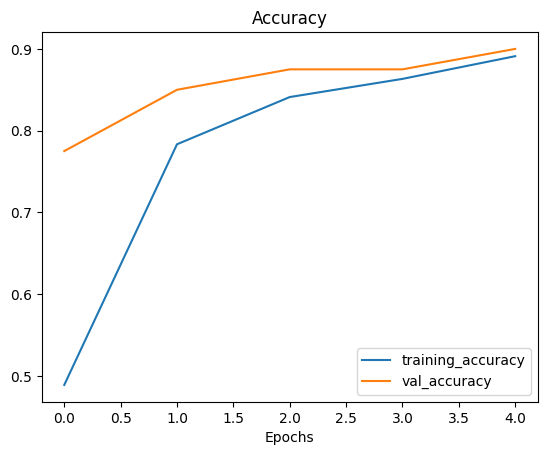

In [26]:
# How does the model go with a data augmentation layer with 1% of data
plot_loss_curves(history_1_percent)


# Model 3: Fine-tuning an existing model on 10% of the data

In [27]:
model_1.layers

In [28]:

for layer in model_1.layers:
  print(layer.trainable)


True
True
False
True
True


In [29]:
model_1.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_layer (InputLayer)    [(None, 224, 224, 3)]     0         
                                                                 
 data_augmentation (Sequent  (None, None, None, 3)     0         
 ial)                                                            
                                                                 
 efficientnetb0 (Functional  (None, None, None, 1280   4049571   
 )                           )                                   
                                                                 
 global_average_pooling_lay  (None, 1280)              0         
 er (GlobalAveragePooling2D                                      
 )                                                               
                                                                 
 output_layer (Dense)        (None, 6)                 7686

In [30]:
# How many layers are trainable in our base model?
print(len(model_1.layers[2].trainable_variables))

0


In [40]:
base_model.trainable = True

# Freeze all layers except for the
for layer in base_model.layers[:-10]:
  layer.trainable = False

# Recompile the model (always recompile after any adjustments to a model)
model_1.compile(loss="categorical_crossentropy",
              optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001), # lr is 10x lower than before for fine-tuning
              metrics=["accuracy"])

In [ ]:
# Check which layers are tuneable (trainable)
for layer_number, layer in enumerate(base_model.layers):
  print(layer_number, layer.name, layer.trainable)

In [42]:
print(len(model_1.trainable_variables))

12


In [44]:
# Fine tune for another 5 epochs

fine_tune_epochs = 10

# Refit the model
history_model_1_fine_tunned= model_1.fit(train_data,
                                               epochs=fine_tune_epochs,
                                               validation_data=test_data,
                                               initial_epoch=history_1_percent.epoch[-1], # start from previous last epoch
                                               validation_steps= len(test_data),
)

Epoch 5/10
29/29 [==============================] - 10s 352ms/step - loss: 0.1249 - accuracy: 0.9644 - val_loss: 0.3440 - val_accuracy: 0.8750
Epoch 6/10
29/29 [==============================] - 10s 349ms/step - loss: 0.0869 - accuracy: 0.9800 - val_loss: 0.3374 - val_accuracy: 0.9000
Epoch 7/10
29/29 [==============================] - 9s 300ms/step - loss: 0.0703 - accuracy: 0.9867 - val_loss: 0.3658 - val_accuracy: 0.8250
Epoch 8/10
29/29 [==============================] - 10s 342ms/step - loss: 0.0675 - accuracy: 0.9867 - val_loss: 0.4182 - val_accuracy: 0.9000
Epoch 9/10
29/29 [==============================] - 12s 394ms/step - loss: 0.0499 - accuracy: 0.9933 - val_loss: 0.3721 - val_accuracy: 0.8750
Epoch 10/10
29/29 [==============================] - 7s 259ms/step - loss: 0.0494 - accuracy: 0.9878 - val_loss: 0.4387 - val_accuracy: 0.8750


In [45]:
def compare_historys(original_history, new_history, initial_epochs=5):
    """
    Compares two model history objects.
    """
    # Get original history measurements
    acc = original_history.history["accuracy"]
    loss = original_history.history["loss"]

    print(len(acc))

    val_acc = original_history.history["val_accuracy"]
    val_loss = original_history.history["val_loss"]

    # Combine original history with new history
    total_acc = acc + new_history.history["accuracy"]
    total_loss = loss + new_history.history["loss"]

    total_val_acc = val_acc + new_history.history["val_accuracy"]
    total_val_loss = val_loss + new_history.history["val_loss"]

    print(len(total_acc))
    print(total_acc)

    # Make plots
    plt.figure(figsize=(8, 8))
    plt.subplot(2, 1, 1)
    plt.plot(total_acc, label='Training Accuracy')
    plt.plot(total_val_acc, label='Validation Accuracy')
    plt.plot([initial_epochs-1, initial_epochs-1],
              plt.ylim(), label='Start Fine Tuning') # reshift plot around epochs
    plt.legend(loc='lower right')
    plt.title('Training and Validation Accuracy')

    plt.subplot(2, 1, 2)
    plt.plot(total_loss, label='Training Loss')
    plt.plot(total_val_loss, label='Validation Loss')
    plt.plot([initial_epochs-1, initial_epochs-1],
              plt.ylim(), label='Start Fine Tuning') # reshift plot around epochs
    plt.legend(loc='upper right')
    plt.title('Training and Validation Loss')
    plt.xlabel('epoch')
    plt.show()

5
11
[0.4888888895511627, 0.7833333611488342, 0.8411111235618591, 0.8633333444595337, 0.8911111354827881, 0.9644444584846497, 0.9800000190734863, 0.9866666793823242, 0.9866666793823242, 0.9933333396911621, 0.9877777695655823]


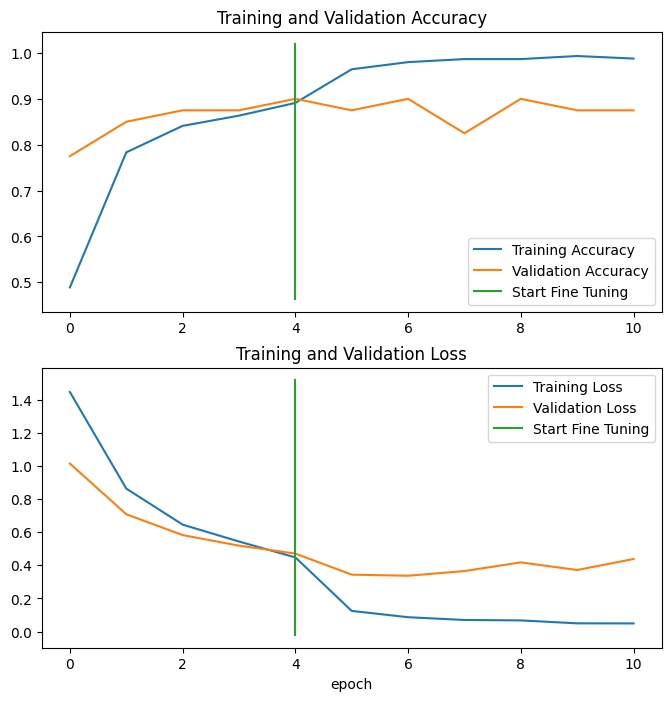

In [46]:

# How did fine-tuning go with more data?
compare_historys(original_history=history_1_percent,
                 new_history=history_model_1_fine_tunned,
                 initial_epochs=5)

In [48]:
base_model.trainable = True

# Freeze all layers except for the
for layer in base_model.layers[:-20]:
  layer.trainable = False

# Recompile the model (always recompile after any adjustments to a model)
model_1.compile(loss="categorical_crossentropy",
              optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001), # lr is 10x lower than before for fine-tuning
              metrics=["accuracy"])

In [ ]:
for layer_number, layer in enumerate(base_model.layers):
  print(layer_number, layer.name, layer.trainable)


In [50]:
# Fine tune for another 5 epochs

fine_tune_epochs = 15

# Refit the model
history_model_1_fine_tunned= model_1.fit(train_data,
                                               epochs=fine_tune_epochs,
                                               validation_data=test_data,
                                               initial_epoch=history_model_1_fine_tunned.epoch[-1], # start from previous last epoch
                                               validation_steps= len(test_data),
)

Epoch 10/15
29/29 [==============================] - 22s 409ms/step - loss: 0.0391 - accuracy: 0.9911 - val_loss: 0.3885 - val_accuracy: 0.9000
Epoch 11/15
29/29 [==============================] - 10s 348ms/step - loss: 0.0331 - accuracy: 0.9933 - val_loss: 0.4466 - val_accuracy: 0.8500
Epoch 12/15
29/29 [==============================] - 10s 317ms/step - loss: 0.0177 - accuracy: 0.9978 - val_loss: 0.3954 - val_accuracy: 0.9000
Epoch 13/15
29/29 [==============================] - 8s 264ms/step - loss: 0.0116 - accuracy: 0.9989 - val_loss: 0.4675 - val_accuracy: 0.9000
Epoch 14/15
29/29 [==============================] - 8s 281ms/step - loss: 0.0173 - accuracy: 0.9944 - val_loss: 0.3996 - val_accuracy: 0.9000
Epoch 15/15
29/29 [==============================] - 8s 273ms/step - loss: 0.0124 - accuracy: 0.9989 - val_loss: 0.4431 - val_accuracy: 0.9000


5
11
[0.4888888895511627, 0.7833333611488342, 0.8411111235618591, 0.8633333444595337, 0.8911111354827881, 0.9911110997200012, 0.9933333396911621, 0.9977777600288391, 0.9988889098167419, 0.9944444298744202, 0.9988889098167419]


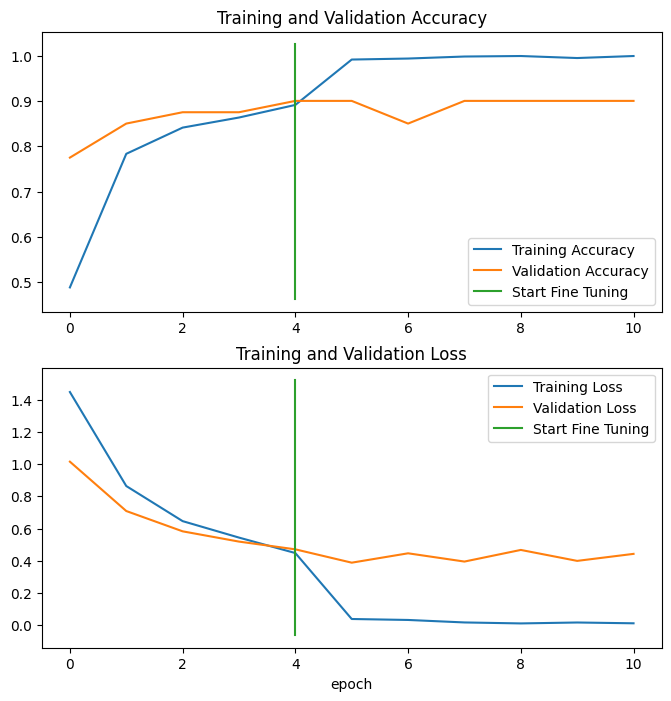

In [52]:
compare_historys(
    history_1_percent,
    history_model_1_fine_tunned,

)